In [1]:
### imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib
import statsmodels.api as sm

#load data
train = pd.read_csv('./application_train.csv')
# test = pd.read_csv('application_test.csv')
# bureau = pd.read_csv('./bureau.csv')
# bureau_balance = pd.read_csv('./bureau_balance.csv')
# credit_balance = pd.read_csv('./credit_card_balance.csv')
# installment_payments = pd.read_csv('./installments_payments.csv')
# cash_balance = pd.read_csv('./POS_CASH_balance.csv')
# previous_application = pd.read_csv('previous_application.csv')



train.drop(['COMMONAREA_MODE',
'COMMONAREA_MEDI',
'COMMONAREA_AVG',
'NONLIVINGAPARTMENTS_MODE',
'NONLIVINGAPARTMENTS_AVG',
'NONLIVINGAPARTMENTS_MEDI',
'FONDKAPREMONT_MODE',
'LIVINGAPARTMENTS_MODE',
'LIVINGAPARTMENTS_MEDI',
'LIVINGAPARTMENTS_AVG',
'FLOORSMIN_AVG',
'FLOORSMIN_MODE',
'FLOORSMIN_MEDI',
'YEARS_BUILD_AVG',
'YEARS_BUILD_MEDI',
'YEARS_BUILD_MODE',
'LANDAREA_AVG',
'LANDAREA_MEDI',
'LANDAREA_MODE',
'BASEMENTAREA_MODE',
'BASEMENTAREA_AVG',
'BASEMENTAREA_MEDI',
'NONLIVINGAREA_AVG',
'NONLIVINGAREA_MEDI',
'NONLIVINGAREA_MODE',
'ELEVATORS_MODE',
'ELEVATORS_MEDI',
'ELEVATORS_AVG',
'WALLSMATERIAL_MODE',
'APARTMENTS_MEDI',
'APARTMENTS_AVG',
'APARTMENTS_MODE',
'ENTRANCES_MODE',
'ENTRANCES_AVG',
'ENTRANCES_MEDI',
'LIVINGAREA_AVG',
'LIVINGAREA_MODE',
'LIVINGAREA_MEDI',
'HOUSETYPE_MODE',
'FLOORSMAX_MODE',
'FLOORSMAX_AVG',
'FLOORSMAX_MEDI',
'YEARS_BEGINEXPLUATATION_MODE',
'YEARS_BEGINEXPLUATATION_AVG',
'YEARS_BEGINEXPLUATATION_MEDI',
'TOTALAREA_MODE',
'EMERGENCYSTATE_MODE'], axis = 1, inplace = True)

# drop rows with missing ext source 2
train = train.dropna(subset = ['EXT_SOURCE_2'])
#dropping those values
train = train.dropna(subset = ['AMT_ANNUITY'])
#dropping those values
train = train.dropna(subset = ['AMT_GOODS_PRICE'])


#### creating model to impute credit scores
ext_sources = train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].copy()
ext_sources = ext_sources.dropna(subset = ['EXT_SOURCE_2','EXT_SOURCE_3','EXT_SOURCE_1'])

X = ext_sources[["EXT_SOURCE_2","EXT_SOURCE_3" ]]
y = ext_sources["EXT_SOURCE_1"]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

#impute 1 with only 2
ext_sources_2 = train[['EXT_SOURCE_1','EXT_SOURCE_2']].copy()
ext_sources = ext_sources.dropna(subset = ['EXT_SOURCE_2','EXT_SOURCE_1'])
X = ext_sources[["EXT_SOURCE_2"]]
y = ext_sources["EXT_SOURCE_1"]
model_2 = sm.OLS(y, X).fit()

#impute 1 with only 3
ext_sources = ext_sources.dropna(subset = ['EXT_SOURCE_3','EXT_SOURCE_1'])
X = ext_sources[["EXT_SOURCE_3" ]]
y = ext_sources["EXT_SOURCE_1"]
model_3 = sm.OLS(y, X).fit()


# coefficients come from models above
import numpy as np
def make_one_happen(b):
    a= 0
    one_estimator = []
    while a < len(b.index):
   #EXT 2 is missing, only 3 
        if np.isnan(b.iloc[a,0]) and np.isnan(b.iloc[a,1]) == False:
            hold_ans = 0.9140 * b.iloc[a,1]
       #EXT 3 is missing, only 2
        elif np.isnan(b.iloc[a,0]) == False and np.isnan(b.iloc[a,1]):
            hold_ans = 0.8837*b.iloc[a,0]
        elif np.isnan(b.iloc[a,0]) and np.isnan(b.iloc[a,1]):
            hold_ans = 0
        else:
            hold_ans = 0.5233*b.iloc[a,0] + b.iloc[a,1]* 0.4228
        one_estimator.append(hold_ans)
        a += 1
    return one_estimator


testmodOne = train[['EXT_SOURCE_2','EXT_SOURCE_3']].copy()
holder = make_one_happen(testmodOne)
train['CREDIT_SCORE_ONE'] = holder
#finally imputing the results of the model into the column in question
train.loc[np.isnan(train['EXT_SOURCE_1']), 'EXT_SOURCE_1'] = train['CREDIT_SCORE_ONE']

#no model for 2, only few hundred missing, deleted rows

#making the model for imputing three

#model 3 with just one
X = ext_sources[["EXT_SOURCE_1"]]
y = ext_sources["EXT_SOURCE_3"]
three_model_1 = sm.OLS(y, X).fit()
#model with one and two
X = ext_sources[["EXT_SOURCE_1", "EXT_SOURCE_2" ]]
y = ext_sources["EXT_SOURCE_3"]
three_model_full = sm.OLS(y, X).fit()

#now imputing for three

def make_three_happen(b):
    a = 0
    one_estimator = []
    while a < len(b.index):
       #if EXT_SOURCE_2 missing
        if np.isnan(b.iloc[a,1]) and (np.isnan(b.iloc[a,0]) == False):
            hold_ans = 0.8602 * b.iloc[a,0]
        else:
            hold_ans =  0.4175 * b.iloc[a,0] + 0.4834 * b.iloc[a,1]
        one_estimator.append(hold_ans)
        a += 1
    return one_estimator
testing = train[['EXT_SOURCE_1','EXT_SOURCE_2']].copy()
train['CREDIT_SCORE_THREE']= make_three_happen(testing)
train.loc[np.isnan(train.EXT_SOURCE_3) , 'EXT_SOURCE_3'] = train['CREDIT_SCORE_THREE']



In [2]:


# change columns from Y/N to 1/0
train['FLAG_OWN_CAR'] = train['FLAG_OWN_CAR'].map({'Y':1,'N':0})
train['FLAG_OWN_REALTY'] = train['FLAG_OWN_REALTY'].map({'Y':1,'N':0})


# convert age to years .. drop prior age by days column
train['AGE_YEARS'] = np.around(np.absolute(train['DAYS_BIRTH'])/365)
train= train.drop(['DAYS_BIRTH'], axis = 1)


# convert employment days to years
train['YRS_EMP'] = np.around(np.absolute(train['DAYS_EMPLOYED'])/365)
# correct anomaly outliers that said a large number were employed for 1001 years
train['YRS_EMP'].replace({1001: np.nan}, inplace = True)
train = train.drop(['DAYS_EMPLOYED'], axis =1)
# convert days of registration to years
train['YRS_REGIST'] = np.around(np.absolute(train['DAYS_REGISTRATION'])/365)
train = train.drop(['DAYS_REGISTRATION'], axis= 1)

# convert days id publish to years
train['YRS_ID_PUB'] = np.around(np.absolute(train['DAYS_ID_PUBLISH'])/365)
train = train.drop(['DAYS_ID_PUBLISH'], axis = 1)

# convert phone change days to years
train['YRS_PHONE_CHG'] = np.around(np.absolute(train['DAYS_LAST_PHONE_CHANGE'])/365)
train = train.drop(['DAYS_LAST_PHONE_CHANGE'],axis = 1)

# impute missing years phn chg with mode
train['YRS_PHONE_CHG']= train['YRS_PHONE_CHG'].fillna(0)


#amt_annuity
train['AMT_ANNUITY'].isnull().sum()
#dropping those values
train= train.dropna(subset = ['AMT_ANNUITY'])


#replace missing values for occupation with "unknown"
train['OCCUPATION_TYPE']=train['OCCUPATION_TYPE'].fillna('unknown')
# replace XNA with NA for occupation type
train.replace('XNA', 'unknown', inplace = True)



# flag has car / no car
b= []
for a in train['OWN_CAR_AGE']:
    if a == 'unknown':
        b.append(0)
    else:
        b.append(1)

train['CAR_OWNER'] = b

train= train.drop(['OWN_CAR_AGE'], axis = 1)

#name_type_suite imputation

train['NAME_TYPE_SUITE']=train['NAME_TYPE_SUITE'].fillna('Unknown')

# impute with mode
train['OBS_30_CNT_SOCIAL_CIRCLE'] = train['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(train['OBS_30_CNT_SOCIAL_CIRCLE'].mode()[0])
train['OBS_60_CNT_SOCIAL_CIRCLE'] = train['OBS_60_CNT_SOCIAL_CIRCLE'].fillna(train['OBS_60_CNT_SOCIAL_CIRCLE'].mode()[0])
train['DEF_30_CNT_SOCIAL_CIRCLE'] = train['DEF_30_CNT_SOCIAL_CIRCLE'].fillna(train['DEF_30_CNT_SOCIAL_CIRCLE'].mode()[0])
train['DEF_60_CNT_SOCIAL_CIRCLE'] = train['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(train['DEF_60_CNT_SOCIAL_CIRCLE'].mode()[0])

train['AMT_REQ_CREDIT_BUREAU_HOUR'] = train['AMT_REQ_CREDIT_BUREAU_HOUR'].fillna(train['AMT_REQ_CREDIT_BUREAU_HOUR'].mode()[0])
train['AMT_REQ_CREDIT_BUREAU_DAY'] = train['AMT_REQ_CREDIT_BUREAU_DAY'].fillna(train['AMT_REQ_CREDIT_BUREAU_DAY'].mode()[0])
train['AMT_REQ_CREDIT_BUREAU_WEEK'] = train['AMT_REQ_CREDIT_BUREAU_WEEK'].fillna(train['AMT_REQ_CREDIT_BUREAU_WEEK'].mode()[0])
train['AMT_REQ_CREDIT_BUREAU_MON'] = train['AMT_REQ_CREDIT_BUREAU_MON'].fillna(train['AMT_REQ_CREDIT_BUREAU_MON'].mode()[0])
train['AMT_REQ_CREDIT_BUREAU_QRT'] = train['AMT_REQ_CREDIT_BUREAU_QRT'].fillna(train['AMT_REQ_CREDIT_BUREAU_QRT'].mode()[0])
train['AMT_REQ_CREDIT_BUREAU_YEAR'] = train['AMT_REQ_CREDIT_BUREAU_YEAR'].fillna(train['AMT_REQ_CREDIT_BUREAU_YEAR'].mode()[0])

# impute median
train['YRS_EMP'] = train['YRS_EMP'].fillna(train['YRS_EMP'].median())


#amt_annuity
train['AMT_GOODS_PRICE'].isnull().sum()

#drop SK_ID_CURR (is a unique id, assumed to have no bearing on results)
train = train.drop('SK_ID_CURR', axis= 1)

# make age bracket column
#bins= [0,20,25,30,35,40,45,50,55,60,65,70,100]
#labels = ['0-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-64','65-69','70+']
#train['AGE_BRACKETS'] = pd.cut(train['AGE_YEARS'], bins=bins, labels=labels, right=False)


# new features
train['AMT_CREDIT_VS_GOODS_PRICE'] = train['AMT_CREDIT'] - train['AMT_GOODS_PRICE']
train['RATIO_AMT_CREDIT_GOODS_PRICE'] = train['AMT_CREDIT'] / train['AMT_GOODS_PRICE']

train['INCOME_VS_ANNUITY'] = train['AMT_INCOME_TOTAL'] - train['AMT_ANNUITY']
train['RATIO_INCOME_ANNUITY'] = train['AMT_INCOME_TOTAL'] / train['AMT_ANNUITY']

train['ADULT_VS_CHILD'] = train['CNT_FAM_MEMBERS'] - train['CNT_CHILDREN']

train['RATIO_AMT_INCOME_AMT_CREDIT'] = train['AMT_INCOME_TOTAL'] / train['AMT_CREDIT']
train['RATIO_AMT_INCOME_AMT_CREDIT'] = train['AMT_INCOME_TOTAL'] - train['AMT_CREDIT']

train['SUM_AGE_+_EMP'] = train['AGE_YEARS'] + train['YRS_EMP']
train['PROD_AGE_EMP'] = train['AGE_YEARS'] * train['YRS_EMP']

train['SUM_CRED_INC_ANN'] = train[['AMT_CREDIT','AMT_INCOME_TOTAL','AMT_ANNUITY']].sum(axis = 1)

train['TOTAL_AMT_REQ_CREDIT_BUREAU'] = train[['AMT_REQ_CREDIT_BUREAU_DAY',
                                              'AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_WEEK',
                                              'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
                                              'AMT_REQ_CREDIT_BUREAU_YEAR']].sum(axis=1)


train['SUM_EXT_SOURCES'] = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].sum(axis=1)
train['EXT_SOURCE_1_2'] = train['EXT_SOURCE_1']**2
train['EXT_SOURCE_2_2'] = train['EXT_SOURCE_2']**2
train['EXT_SOURCE_3_2'] = train['EXT_SOURCE_3']**2

train['EXT_SOURCE_1_3'] = train['EXT_SOURCE_1']**3
train['EXT_SOURCE_2_3'] = train['EXT_SOURCE_2']**3
train['EXT_SOURCE_3_3'] = train['EXT_SOURCE_3']**3

train['SUM_EXT_SOURCE_2'] = train[['EXT_SOURCE_1_2', 'EXT_SOURCE_2_2', 'EXT_SOURCE_3_2']].sum(axis = 1)
train['SUM_EXT_SOURCE_3'] = train[['EXT_SOURCE_1_3', 'EXT_SOURCE_2_3', 'EXT_SOURCE_3_3']].sum(axis = 1)
train['EXT_SOURCES_AVG'] = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)

# separate categorical and numerical feats
categorical_features = train.select_dtypes(include = ["object"]).columns
numerical_features = train.select_dtypes(exclude = ["object"]).columns
train_num = train[numerical_features]
train_cat = train[categorical_features]

# Create dummy features for categorical values via one-hot encoding
train_cat = pd.get_dummies(train_cat)
# Join categorical and numerical features
train = pd.concat([train_num, train_cat], axis = 1)

train = train.drop(['CREDIT_SCORE_THREE','CREDIT_SCORE_ONE'], axis = 1)

In [3]:
# train.select_dtypes(include = ["object"]).columns

In [4]:
# train['AMT_REQ_CREDIT_BUREAU_YEAR'].value_counts()

In [5]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [6]:
# train['FLAG_OWN_CAR'].value_counts()

In [7]:
# train['DEF_60_CNT_SOCIAL_CIRCLE'].mode()[0]

In [8]:
missing_values_table(train)

Your selected dataframe has 206 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [9]:
#train.to_csv('Train.csv')

In [10]:


#set up for Smote oversampling of minority target
!pip install imblearn
import imblearn
from imblearn.over_sampling import SMOTE
X=train.drop('TARGET', axis= 1)
y = train['TARGET']
print(y.head(10))
smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X, y)



0    1
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: TARGET, dtype: int64


In [11]:
#split train test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.33, random_state=42)

In [12]:
#set up for random forest
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

# random forest model creation
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
# predictions
rfc_predict = rfc.predict(X_test)




C:\Users\houfr\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [15]:
#prints cross validation results of Random Forest
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[92598   449]
 [ 8236 84712]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     93047
           1       0.99      0.91      0.95     92948

    accuracy                           0.95    185995
   macro avg       0.96      0.95      0.95    185995
weighted avg       0.96      0.95      0.95    185995



=== All AUC Scores ===
[0.65657419 0.6508762  0.6525506  0.64335923 0.64963604 0.64753669
 0.64469487 0.66298001 0.6495022  0.64705679]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.6504766830012038


[ 8 11 18 13 19  6 17  3  4  5  7  2 15 10  9  1 12 16 14  0]


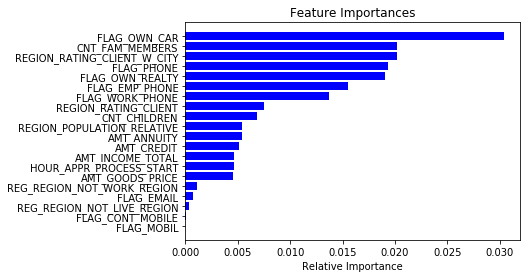

In [16]:
#prints relative importance of features in random forest
import matplotlib
features = train.drop('TARGET', axis=1).columns
importances = rfc.feature_importances_
indices= np.argsort(importances[0:20])
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color = 'b', align = 'center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show



print(indices)

In [18]:
# XG boost work
!pip install xgboost
import xgboost as xgb
from sklearn.metrics import mean_squared_error

xg_cls = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 8)

xg_cls.fit(X_train,y_train)

xg_predict = xg_cls.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, xg_predict))
print("RMSE: %f" % (rmse))

RMSE: 0.263101


In [19]:
#returns a report for the model including confusion matrix, AUC scores etc. for the xg boost
from sklearn.model_selection import cross_val_score
xg_cls_cv_score = cross_val_score(xg_cls, X, y, cv=10, scoring='roc_auc')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, xg_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, xg_predict))
print('\n')
print("=== All AUC Scores ===")
print(xg_cls_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - XG boost: ", xg_cls_cv_score.mean())

=== Confusion Matrix ===
[[92923   124]
 [12751 80197]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     93047
           1       1.00      0.86      0.93     92948

    accuracy                           0.93    185995
   macro avg       0.94      0.93      0.93    185995
weighted avg       0.94      0.93      0.93    185995



=== All AUC Scores ===
[0.72806966 0.73000913 0.73138651 0.72701017 0.72773214 0.72456504
 0.73070529 0.7368088  0.73922636 0.73055737]


=== Mean AUC Score ===
Mean AUC Score - XG boost:  0.7306070468446748


In [ ]:
#bayseian